# 1. Library Imports

In [40]:
import scanpy as sc
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load Pre-Processed Data

In [41]:
adata = sc.read("../data/processed/pbmc3k_preprocessed.h5ad")
print(adata)
print(adata.shape)

AnnData object with n_obs × n_vars = 2638 × 2013
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
(2638, 2013)


# 3. Visualizations and Annotations

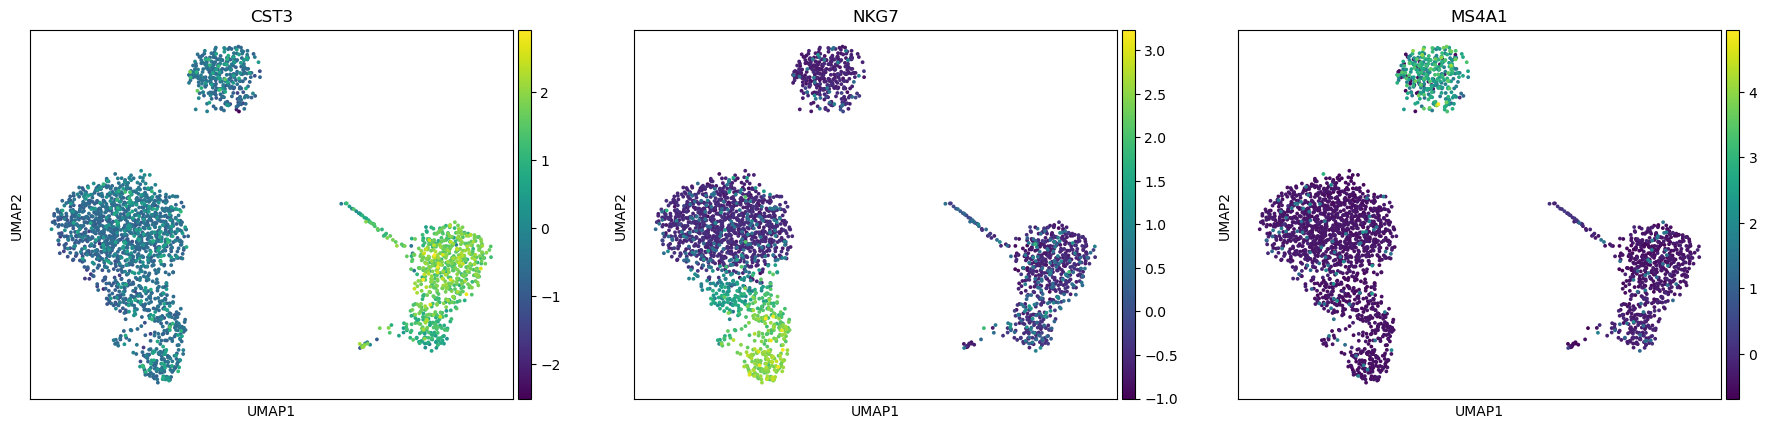

In [42]:
marker_genes = ['CST3', 'NKG7', 'MS4A1']
sc.pl.umap(adata, color=marker_genes, cmap='viridis', size=30)

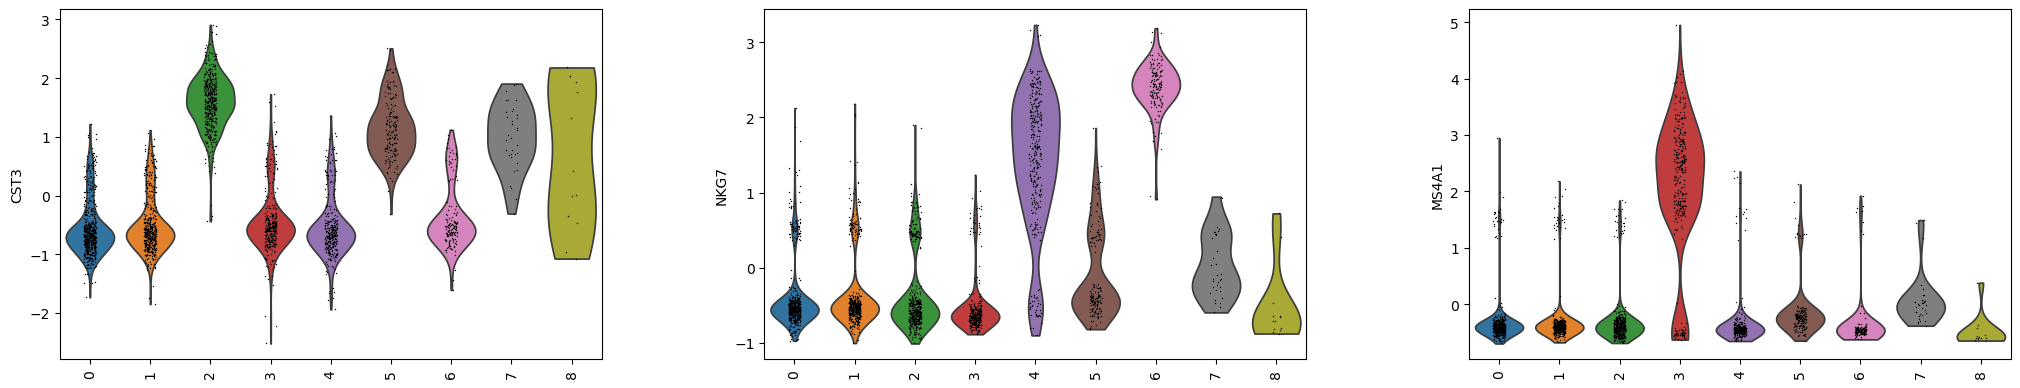

In [43]:
sc.pl.violin(adata, marker_genes, groupby='leiden', rotation=90)

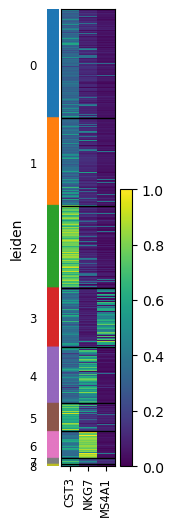

In [44]:
sc.pl.heatmap(adata, var_names=marker_genes, groupby='leiden', standard_scale='var')

In [45]:
cluster_to_celltype = {
    '2': 'Monocytes',  # CST3-high
    '3': 'B cells',    # MS4A1-high
    '6': 'NK cells',   # NKG7-high
}

adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_to_celltype)

adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_to_celltype)

In [46]:
# List of Marker Genes
marker_genes = ['MS4A1','CD19','CD79A','CD3D','CD3E','CD4','CD8A','CD8B','NKG7','NCAM1','GNLY','CST3','CD14','LYZ','FCER1A','CLEC9A','PPBP']

present_markers = [gene for gene in marker_genes if gene in adata.var_names]
print("Markers present in dataset:", present_markers)

Markers present in dataset: ['MS4A1', 'CD19', 'CD79A', 'NKG7', 'GNLY', 'CST3', 'FCER1A', 'PPBP']


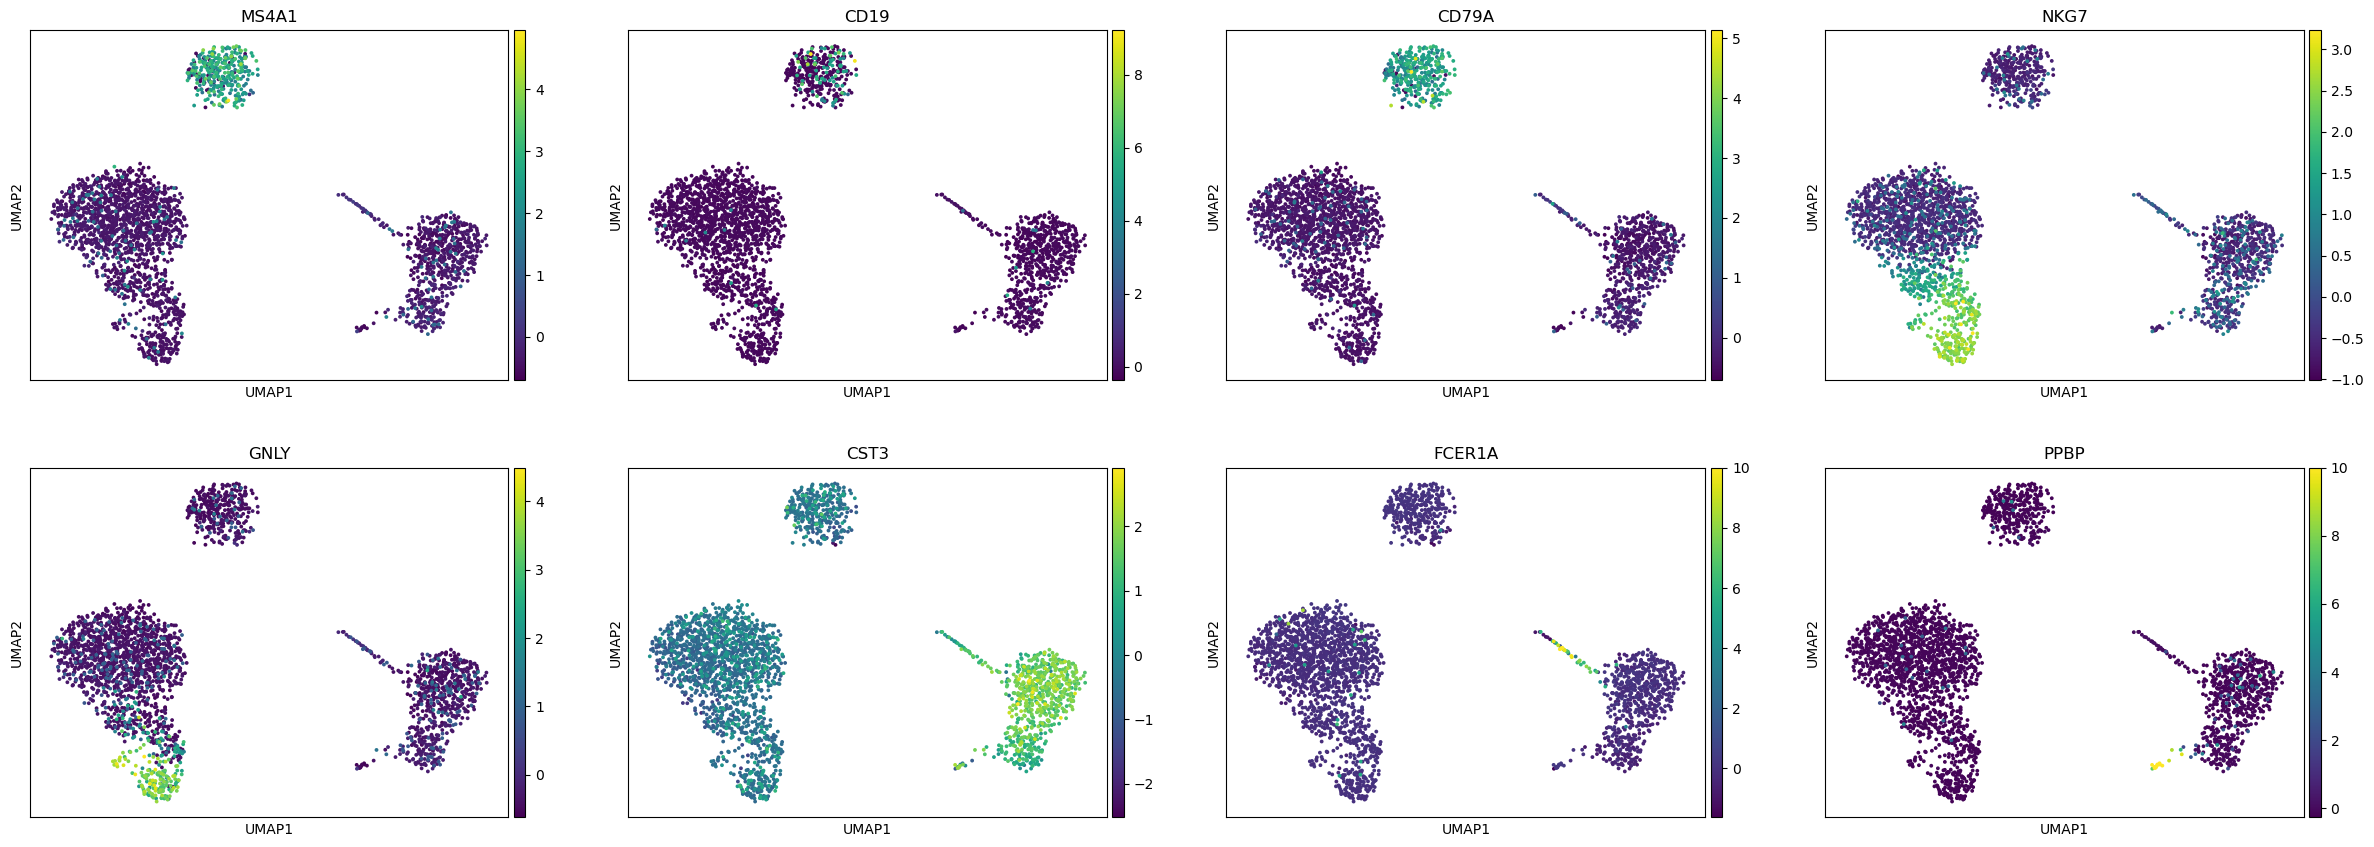

In [47]:
sc.pl.umap(adata, color=present_markers, cmap='viridis', size=30)

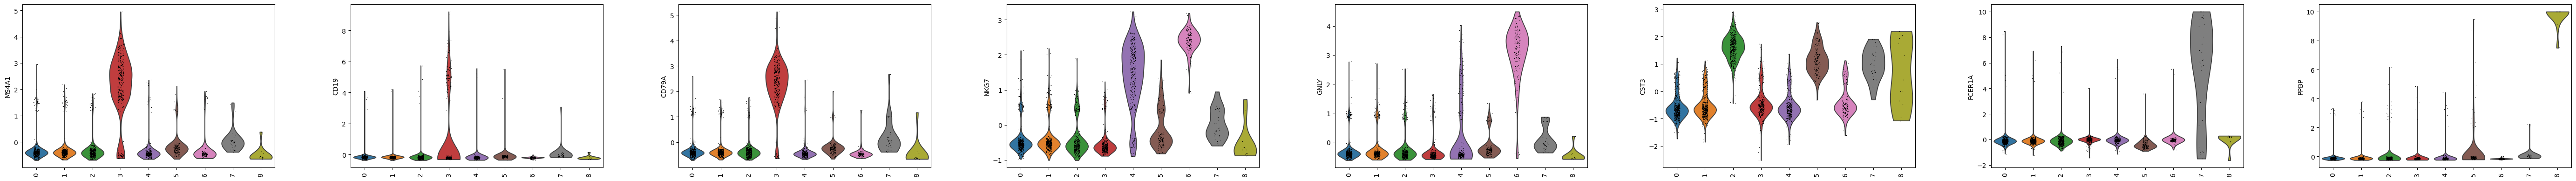

In [48]:
sc.pl.violin(adata, present_markers, groupby='leiden', rotation=90)

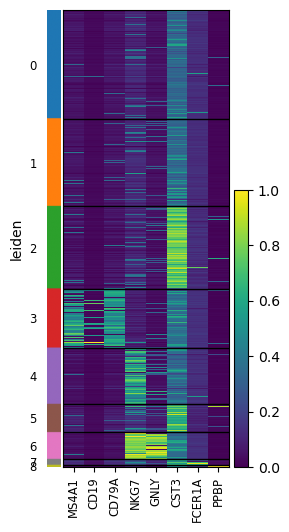

In [49]:
sc.pl.heatmap(adata, var_names=present_markers, groupby='leiden', standard_scale='var')

After performing unsupervised clustering with Leiden Clustering during preprocessing, I annotated the resulting clusters using a **marker gene dictionary** derived from canonical immunology knowledge. Each cluster’s average expression was compared against a curated set of cell type–specific markers, e.g. MS4A1 for B cells, CD3D/CD4 for CD4 T cells, CD3D/CD8A for CD8 T cells, NKG7 for NK cells, CST3/CD14 for monocytes.

In [50]:
# Dictionary of canonical PBMC markers
marker_dict = {
    'B cells': ['MS4A1', 'CD19', 'CD79A'],
    'CD4 T cells': ['CD3D', 'CD3E', 'CD4'],
    'CD8 T cells': ['CD3D', 'CD8A', 'CD8B'],
    'NK cells': ['NKG7', 'NCAM1', 'GNLY'],
    'Monocytes': ['CST3', 'CD14', 'LYZ'],
    'Dendritic cells': ['FCER1A', 'CLEC9A'],
    'Platelets': ['PPBP']
}

for cell_type in marker_dict:
    marker_dict[cell_type] = [gene for gene in marker_dict[cell_type] if gene in adata.var_names]

marker_dict

{'B cells': ['MS4A1', 'CD19', 'CD79A'],
 'CD4 T cells': [],
 'CD8 T cells': [],
 'NK cells': ['NKG7', 'GNLY'],
 'Monocytes': ['CST3'],
 'Dendritic cells': ['FCER1A'],
 'Platelets': ['PPBP']}

In [51]:
def assign_cell_types(adata, cluster_key='leiden', marker_dict=marker_dict):
    cluster_ids = adata.obs[cluster_key].unique()
    cluster_to_celltype = {}
    
    for cluster in cluster_ids:
        cluster_cells = adata[adata.obs[cluster_key] == cluster]
        
        mean_expr = {}
        for cell_type, markers in marker_dict.items():
            if len(markers) == 0:
                continue
            mean_expr[cell_type] = cluster_cells[:, markers].X.mean()
        
        if mean_expr:
            assigned_type = max(mean_expr, key=mean_expr.get)
            cluster_to_celltype[cluster] = assigned_type
        else:
            cluster_to_celltype[cluster] = 'Unknown'
    
    adata.obs['cell_type'] = adata.obs[cluster_key].map(cluster_to_celltype)
    
    return cluster_to_celltype

In [52]:
cluster_mapping = assign_cell_types(adata)
print(cluster_mapping)

{'0': 'Dendritic cells', '3': 'B cells', '1': 'Dendritic cells', '5': 'Monocytes', '6': 'NK cells', '4': 'NK cells', '2': 'Monocytes', '7': 'Dendritic cells', '8': 'Platelets'}


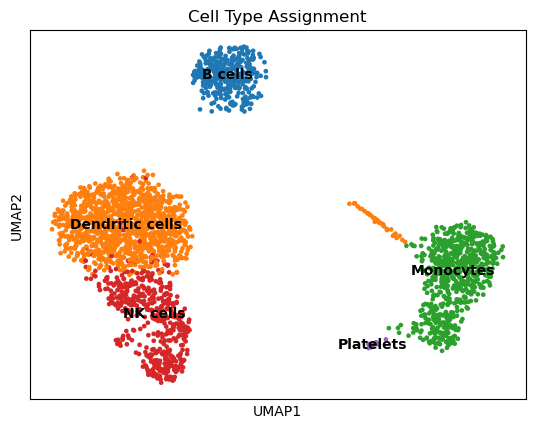

In [53]:
sc.pl.umap(adata, color=['cell_type'], legend_loc='on data', title='Cell Type Assignment')

# 4. Classification

In [54]:
X = adata[:, adata.var["highly_variable"]].X.toarray()
y = adata.obs["cell_type"].values

class_names = np.unique(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [55]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(pd.Categorical(y_train).codes, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(pd.Categorical(y_test).codes, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)

In [56]:
class CellClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 5)
        )
    def forward(self, x):
        return self.network(x)

# Train the Model
model = CellClassifier(input_dim=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
batch_size = 16

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for batch_X, batch_T in train_dl:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_T)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_X.size(0)

        _, preds = torch.max(outputs, 1)
        correct_preds += (preds == batch_T).sum().item()
        total_preds += batch_T.size(0)

    avg_loss = epoch_loss / len(train_ds)
    accuracy = correct_preds / total_preds

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [10/100] Loss: 0.0002, Accuracy: 1.0000
Epoch [20/100] Loss: 0.0001, Accuracy: 1.0000
Epoch [30/100] Loss: 0.0000, Accuracy: 1.0000
Epoch [40/100] Loss: 0.0000, Accuracy: 1.0000
Epoch [50/100] Loss: 0.0000, Accuracy: 1.0000
Epoch [60/100] Loss: 0.0000, Accuracy: 1.0000
Epoch [70/100] Loss: 0.0000, Accuracy: 1.0000
Epoch [80/100] Loss: 0.0000, Accuracy: 1.0000
Epoch [90/100] Loss: 0.0000, Accuracy: 1.0000
Epoch [100/100] Loss: 0.0000, Accuracy: 1.0000


Test Loss: 0.2281, Test Accuracy: 0.9527

Classification Report:
                 precision    recall  f1-score   support

        B cells       0.99      1.00      0.99        68
Dendritic cells       0.94      0.96      0.95       234
      Monocytes       0.99      0.99      0.99       128
       NK cells       0.91      0.85      0.88        96
      Platelets       1.00      1.00      1.00         2

       accuracy                           0.95       528
      macro avg       0.97      0.96      0.96       528
   weighted avg       0.95      0.95      0.95       528

Confusion Matrix:
[[ 68   0   0   0   0]
 [  1 224   1   8   0]
 [  0   1 127   0   0]
 [  0  14   0  82   0]
 [  0   0   0   0   2]]


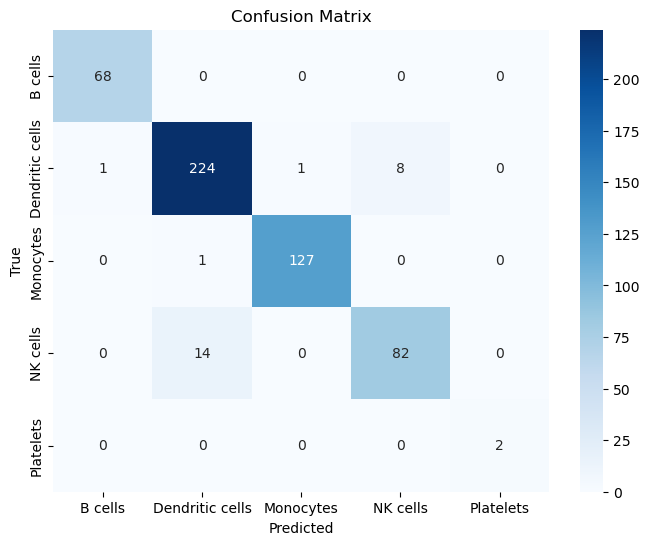

In [60]:
def evaluate(model, test_dl, criterion, class_names=None):
    model.eval()
    test_loss = 0.0
    correct_preds = 0
    total_preds = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_T in test_dl:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_T)

            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == batch_T).sum().item()
            total_preds += batch_T.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_T.cpu().numpy())

    avg_loss = test_loss / len(test_dl)
    accuracy = correct_preds / total_preds

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    if class_names is not None:
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))

        print("Confusion Matrix:")
        print(confusion_matrix(all_labels, all_preds))

    return avg_loss, accuracy, all_preds, all_labels

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

_, _, all_preds, all_labels = evaluate(model, test_dl, criterion, class_names)
plot_confusion_matrix(all_labels, all_preds, class_names)